<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/anshika-dev/Project_Sprint1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Infosys Springboard Internship — Sprint 1

**Purpose:** notebook that fetches market & news data, synthesizes/ingests tweet-like text, runs sentiment analysis (FinBERT + lightweight fallback), and visualizes sentiment vs price trends.

**Team Members:**<br>
Anshika Gupta<br>
Gopichand<br>
Janmejay Singh<br>
Vaishnavi<br>

<!-- Colab badge: opens this notebook in Google Colab -->
<a href="https://colab.research.google.com/github/gopichandchalla16/infosys-internship-real-time-industry-insight-system/blob/main/Project_Sprint1.ipynb" target="_blank">
  <img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/>
</a>

**Quick run**
- **In Google Colab**: click the badge above and run the notebook cells in order (or: `Runtime → Run all`).

**Required environment variables / API keys**
- `ALPHA_VANTAGE_API` — Alpha Vantage API key (for market prices).
- Optional: `SLACK_WEBHOOK_URL` — (for Slack alerts).
Set these either as environment variables or (in Colab) via `google.colab.userdata.set()`.

**Notes & warnings**
- The notebook may download large models (e.g., `ProsusAI/finbert`). This can be slow on CPU and will use significant bandwidth and disk space. A GPU runtime is **recommended** for FinBERT inference.


## Project Overview

This notebook is developed as part of the **Infosys Springboard Internship ** and demonstrates a complete **financial sentiment analysis pipeline** using real-world market and news data.

### 🔹 What this notebook does
1. Accepts a **company name** as user input.
2. Fetches:
   - **Stock market data** from Alpha Vantage / Yahoo Finance
   - **News articles** from Google News RSS
   - **Company description** from Wikipedia
3. Collects or generates **tweet-style financial text**.
4. Performs **sentiment analysis** using:
   - ✅ `ProsusAI/finbert` (finance-specific transformer model)
   - ✅ Lightweight NLP fallback (TextBlob)
5. Produces:
   - 📊 Sentiment distribution plots
   - 📈 Price vs sentiment trend analysis
6. Sends **Slack alerts** based on detected sentiment.

---

### 🔹 Key Outputs Generated
- Processed tweet sentiment (`positive`, `neutral`, `negative`)
- Market trend graph
- Sentiment trend visualization
- Slack notification

---

### ⚠️ Reproducibility Notes
- Internet access is required.
- API keys must be configured before execution.
- Some models require high memory and may run slow on CPU-only systems.



In [68]:
# =========================
# USER INPUT (RESTRICTED TO PREDEFINED LIST)
# =========================

ALLOWED_COMPANIES = {
    "NETFLIX",
    "APPLE",
    "TESLA",
    "GOOGLE",
    "MICROSOFT",
    "TCS",
    "INFOSYS",
    "RAKUTEN",
    "BITCOIN",
    "AMAZON",
    "META",
    "NVIDIA",
    "AMD",
    "INTEL",
    "JP MORGAN",
    "GOLDMAN SACHS",
    "MASTERCARD",
    "VISA",
    "RELIANCE",
    "HDFC",
    "ICICI",
    "WIPRO",
    "HCL",
    "ADANIPORTS",
    "ADANIENT",
    "TATA MOTORS",
    "MARUTI",
    "COCA COLA",
    "PEPSICO",
    "WALMART",
    "ETHEREUM",
    "DOGECOIN",
    "SOLANA"
}

def get_valid_company_name():
    """
    Restricts user input strictly to a predefined list of companies.
    Ignores case and extra spaces.

    Returns:
        str: Validated company name
    """

    print("✅ Please select a company ONLY from the list below:\n")
    for name in (ALLOWED_COMPANIES):
        print("•", name)

    print("\n--------------------------------------")

    while True:
        user_input = input("Enter company name exactly as shown above: ").strip().upper()

        # ❌ Empty input
        if not user_input:
            print("❌ Input cannot be empty. Please select from the provided list.")
            continue

        # ❌ Invalid company
        if user_input not in ALLOWED_COMPANIES:
            print("❌ Invalid selection. Please select from the provided list only.")
            continue

        return user_input.title()


# Collect validated input
company_name = get_valid_company_name()

print(f"\n✅ Selected company for analysis: {company_name}")


✅ Please select a company ONLY from the list below:

• MASTERCARD
• ICICI
• BITCOIN
• AMAZON
• VISA
• SOLANA
• WALMART
• NETFLIX
• MARUTI
• RELIANCE
• NVIDIA
• TESLA
• ETHEREUM
• HCL
• GOLDMAN SACHS
• INFOSYS
• WIPRO
• ADANIPORTS
• DOGECOIN
• TATA MOTORS
• ADANIENT
• AMD
• APPLE
• HDFC
• PEPSICO
• COCA COLA
• GOOGLE
• TCS
• META
• RAKUTEN
• MICROSOFT
• INTEL
• JP MORGAN

--------------------------------------
Enter company name exactly as shown above: netflix

✅ Selected company for analysis: Netflix


##  Step 2: Import Required Libraries
We use the following Python libraries:
- `requests` & `BeautifulSoup` for scraping web data
- `pandas` for data manipulation
- `matplotlib` & `seaborn` for visualization
- `textblob` for sentiment analysis
- `yfinance` for market data
- `wikipedia` for Wikipedia summaries


In [69]:
# =========================
# SAFE PACKAGE INSTALLATION & VERIFICATION
# =========================

import sys
import subprocess
import importlib

REQUIRED_PACKAGES = [
    "transformers",
    "torch",
    "yfinance",
    "alpha-vantage",
    "textblob",
    "feedparser",
    "beautifulsoup4",
    "faker",
    "pandas",
    "numpy",
    "matplotlib",
    "wikipedia",
    "requests"
]

def install_if_missing(package):
    try:
        importlib.import_module(package.replace("-", "_"))
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"⏳ Installing {package} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install all required packages
for pkg in REQUIRED_PACKAGES:
    install_if_missing(pkg)

print("\n✅ Package installation complete.")


# 🔥 Hardware & Runtime Warning
try:
    import torch
    if not torch.cuda.is_available():
        print("⚠️ GPU not detected. FinBERT will run slowly on CPU.")
    else:
        print("✅ GPU detected. FinBERT will run efficiently.")
except:
    print("⚠️ Torch not loaded yet. GPU detection skipped.")


✅ transformers already installed
✅ torch already installed
✅ yfinance already installed
✅ alpha-vantage already installed
✅ textblob already installed
✅ feedparser already installed
⏳ Installing beautifulsoup4 ...
✅ faker already installed
✅ pandas already installed
✅ numpy already installed
✅ matplotlib already installed
✅ wikipedia already installed
✅ requests already installed

✅ Package installation complete.
⚠️ GPU not detected. FinBERT will run slowly on CPU.


## 📘 Company Overview Retrieval (Wikipedia)

This section retrieves a **brief public overview of the selected company** using the official Wikipedia API. This provides:

- ✅ Business background
- ✅ Industry context
- ✅ General understanding before data analysis
- ✅ Human-readable description for reports and dashboards  

---

### 🔹 Why this step is important
- Helps users understand **what entity is being analyzed**
- Adds **context to sentiment and market trends**

---

### 🔹 What this cell does
- Queries Wikipedia using the validated `company_name`
- Automatically resolves:
  - Page disambiguation (e.g., multiple meanings of the same name)
  - Missing pages
  - Network failures
- Limits the output to a **short readable summary**

---

### ⚠️ Failure Handling & Reliability
This cell is designed to **never crash the notebook** even if:
- The company page does not exist
- Multiple Wikipedia pages match
- Internet access is unavailable  
In all cases, a meaningful fallback message is returned.

---

### ✅ Output
A short textual description of the selected company or asset that will be displayed to the user before market and sentiment analysis begins.


In [70]:
# =========================
# ROBUST WIKIPEDIA COMPANY OVERVIEW FETCH
# =========================

import wikipedia


def _generate_variants(name):
    variants = [
        name,
        f"{name} Inc.",
        f"{name}, Inc.",
        f"{name} Corporation",
        f"{name} Company",
        f"{name} Ltd.",
        f"{name} (company)",
        f"{name} (company)",
        f"{name} (film)",
        f"{name} (cryptocurrency)"
    ]

    seen = set()
    out = []
    for v in variants:
        if v.lower() not in seen:
            seen.add(v.lower())
            out.append(v)
    return out

def fetch_wikipedia_summary(company_name, max_sentences=10):
    """
    Robustly fetch a short Wikipedia summary for a company/asset.
    Tries: direct lookup, wikipedia.search suggestions, common name variants,
    and gracefully handles disambiguation/page/network errors.

    Returns:
        str: Short summary or informative fallback message.
    """
    # 1) Try direct summary first (fast path)
    try:
        return wikipedia.summary(company_name, sentences=max_sentences)
    except wikipedia.exceptions.DisambiguationError as e:
        # Will fall through to search-based resolution below
        pass
    except wikipedia.exceptions.PageError:
        pass
    except Exception:
        # Network or unexpected failure — we'll try search but keep fallback
        pass

    # 2) Try searching for likely titles
    try:
        search_results = wikipedia.search(company_name, results=8)
    except Exception:
        search_results = []

    # 3) If search returned candidates, pick the best (first) candidate and fetch summary
    for candidate in search_results:
        try:
            # Avoid picking obviously irrelevant short matches (like single letters)
            if len(candidate) < 2:
                continue
            summary = wikipedia.summary(candidate, sentences=max_sentences)
            return summary
        except wikipedia.exceptions.DisambiguationError:
            # If candidate is ambiguous, try the first option from its disambiguation
            try:
                dis_opt = wikipedia.search(candidate, results=1)
                if dis_opt:
                    summary = wikipedia.summary(dis_opt[0], sentences=max_sentences)
                    return summary
            except Exception:
                continue
        except Exception:
            continue

    # 4) Try helpful title variants (Inc., Ltd., Corporation, etc.)
    for variant in _generate_variants(company_name):
        try:
            summary = wikipedia.summary(variant, sentences=max_sentences)
            return summary
        except Exception:
            continue

    # 5) Final fallback
    return (f"⚠️ Could not reliably fetch a Wikipedia summary for '{company_name}'. "
            "This may be due to ambiguous names or missing pages. ")

# Usage: get the summary and print it
wiki_summary = fetch_wikipedia_summary(company_name)
print("\n📘 Company Overview (Wikipedia):\n")
print(wiki_summary)



📘 Company Overview (Wikipedia):

Netflix is an American subscription video on-demand over-the-top streaming service. The service primarily distributes original and acquired films and television shows from various genres, and it is available internationally in multiple languages.
Launched in 2007, nearly a decade after Netflix, Inc. began its pioneering DVD-by-mail movie rental service, Netflix is the most-subscribed video on demand streaming media service, with 301.6 million paid memberships in more than 190 countries as of 2025. By 2022, "Netflix Original" productions accounted for half of its library in the United States and the namesake company had ventured into other categories, such as video game publishing of mobile games through its flagship service. As of 2025, Netflix is the 18th most-visited website in the world, with 21.18% of its traffic coming from the United States, followed by the United Kingdom at 6.01%, Canada at 4.94%, and Brazil at 4.24%.


== History ==


=== Launc

## 📊 Market Data Retrieval (Stocks & Crypto)

This section retrieves **historical price data** for the selected company or cryptocurrency.


### 🔹 What this cell does
- Automatically detects and fetches:
  - **Stock market data** (e.g., Tesla, Apple, Reliance)
  - **Cryptocurrency data** (e.g., Bitcoin, Ethereum)
- Uses **Yahoo Finance (`yfinance`)** as the primary data source
- Fetches:
  - Daily closing prices
  - Date-wise time-series data for the last few months

---

### 🔹 Why this step is important
- Provides the **numerical basis** for:
  - Trend analysis
  - Graph plotting
  - Market movement interpretation

---

### ⚠️ Failure Handling & Reliability
This cell is designed to **fail safely without stopping the notebook** if:
- The ticker symbol is invalid
- Internet connection is unavailable
- The API does not return data
- The selected asset is delisted or inactive

In such cases:
- A warning message is printed
- An empty DataFrame is returned
- Downstream plotting is automatically skipped

---

### ✅ Output
- A validated DataFrame with:
  - `Date`
  - `Open`
  - `High`
  - `Low`
  - `Volume`
  - `Close`

This structured output is passed directly to the visualization and analysis stages.


In [71]:
# =========================
# SAFE MARKET DATA FETCH (STOCKS + CRYPTO)
# =========================

import pandas as pd
import yfinance as yf
from datetime import datetime

tickers = {
    "NETFLIX": "NFLX",
    "APPLE": "AAPL",
    "TESLA": "TSLA",
    "GOOGLE": "GOOGL",
    "MICROSOFT": "MSFT",
    "TCS": "TCS.NS",
    "INFOSYS": "INFY.NS",
    "RAKUTEN": "RKUNY",
    "BITCOIN": "BTC-USD",
    "AMAZON": "AMZN",
    "META": "META",
    "NVIDIA": "NVDA",
    "AMD": "AMD",
    "INTEL": "INTC",
    "JP MORGAN": "JPM",
    "GOLDMAN SACHS": "GS",
    "MASTERCARD": "MA",
    "VISA": "V",
    "RELIANCE": "RELIANCE.NS",
    "HDFC": "HDFCBANK.NS",
    "ICICI": "ICICIBANK.NS",
    "WIPRO": "WIPRO.NS",
    "HCL": "HCLTECH.NS",
    "ADANIPORTS": "ADANIPORTS.NS",
    "ADANIENT": "ADANIENT.NS",
    "TATA MOTORS": "TATAMOTORS.NS",
    "MARUTI": "MARUTI.NS",
    "TESLA": "TSLA",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",
    "NETFLIX": "NFLX",
    "ETHEREUM": "ETH-USD",
    "DOGECOIN": "DOGE-USD",
    "SOLANA": "SOL-USD"
}

def fetch_market_data(asset_name, period="1mo", interval="1d"):
    """
    Safely fetches historical market data for stocks and crypto.

    Returns:
        DataFrame with Date and Close price, or empty DataFrame on failure.
    """
    try:
        asset_name = tickers.get(company_name.upper(), company_name.upper())
        ticker = yf.Ticker(asset_name)
        market_data = ticker.history(period=period, interval=interval)

        if market_data is None or market_data.empty:
            print(f"⚠️ No market data found for: {asset_name}")
            return pd.DataFrame()

        market_data = market_data.reset_index()

        if "Close" not in market_data.columns:
            print(f"⚠️ 'Close' price column missing for: {asset_name}")
            return pd.DataFrame()

        return market_data[['Date','Open','High','Low','Close','Volume']]

    except Exception as e:
        print(f"⚠️ Market data fetch failed for {asset_name}: {e}")
        return pd.DataFrame()


# Fetch data using validated company selection
market_df = fetch_market_data(company_name)

# Final validation before proceeding
if market_df.empty:
    print("❌ Market data unavailable. Downstream trend analysis will be skipped.")
else:
    print("✅ Market data successfully retrieved!")
    display(market_df.head())


✅ Market data successfully retrieved!


,Date,Open,High,Low,Close,Volume
0,2025-11-06 00:00:00-05:00,109.458000,110.370003,108.513000,109.702003,36532000
1,2025-11-07 00:00:00-05:00,109.417999,110.821999,108.750000,110.365997,44125000
2,2025-11-10 00:00:00-05:00,110.671997,112.820000,110.404999,112.007004,36929000
3,2025-11-11 00:00:00-05:00,111.760002,113.921997,111.279999,113.643997,27966000
4,2025-11-12 00:00:00-05:00,113.817001,116.433998,112.825996,115.750000,39221000


## 📰 News Data Collection

This cell fetches the **latest news related to the selected company/asset** using Google News RSS feeds.  
The extracted headlines are later used for **sentiment analysis**.


In [72]:
# =========================
# SAFE NEWS FETCH WITH LINKS (GOOGLE NEWS RSS)
# =========================

import feedparser
import re

def clean_text(text):
    """Removes HTML tags and extra spaces."""
    text = re.sub(r"<.*?>", "", text)
    return re.sub(r"\s+", " ", text).strip()


def fetch_company_news_with_links(company_name, max_articles=10):
    """
    Safely fetches latest news headlines and links for a given company using Google News RSS.

    Returns:
        list of dictionaries with 'title' and 'link'
    """
    try:
        query = company_name.replace(" ", "+")
        rss_url = f"https://news.google.com/rss/search?q={query}"

        feed = feedparser.parse(rss_url)

        if not feed.entries:
            print("⚠️ No news articles found.")
            return []

        news_list = []
        seen_titles = set()

        for entry in feed.entries[:max_articles]:
            title = clean_text(entry.title)
            link = entry.link

            # Avoid duplicate titles
            if title.lower() not in seen_titles:
                seen_titles.add(title.lower())
                news_list.append({"title": title, "link": link})

        return news_list

    except Exception as e:
        print("⚠️ News fetch failed:", e)
        return []



news_articles_with_links = fetch_company_news_with_links(company_name)

print(f"\n📰 Total News Articles Fetched: {len(news_articles_with_links)}\n")

if news_articles_with_links:
    for i, article in enumerate(news_articles_with_links, 1):
        print(f"{i}. {article['title']}")
        print(f"   → Link: {article['link']}\n")
else:
    print("⚠️ No news data available.")



📰 Total News Articles Fetched: 10

1. The regulatory path ahead for a Netflix and Warner Bros. deal could get dicey - CNBC
   → Link: https://news.google.com/rss/articles/CBMiigFBVV95cUxNUXA0bmsyVmRiN3M5dTFCczBPZ1FYWExlaHgxd2ktQTF5dktqNWNNb0VNbVJLbkxKWEsyT3dvV21TeEplcnhJdGU0SkpRRUk2YXNSbzV4SS1Kc01yR3VYNk1zSjg2eDJKSE9SckFjQ1pGT05Mb1R6Z1FCalE1dnNOWEJTMXlIOXBISXfSAY8BQVVfeXFMTWV1RE5rOE1mMDVqel8yMkMxQ3NWMVZmMVNtRWNCUk03U0pBc1JONWdiUnVwZGVtMHlTQzRNMmV0ejVndlZmWFBERk1xR2NLMWluSlYtU1hmcGJrN2lkYzFOWFY5T0FjSXNZeHpMSy1uYkFJcU9CRWNxbTZvZHdZRW5TSEl6WXY5cy1qaC1GMkk?oc=5

2. 'The Abandons' is a sudsy soap opera dressed up in spurs and a cowboy hat - NPR
   → Link: https://news.google.com/rss/articles/CBMifkFVX3lxTE5YNXR1X1ptbVZQYkRfVTFneFJjdnd4ZmwyeThOdmx6aUVJcmc1ZU9wcU5uWHAxbXNzQlNpbU1reFdOWmZISnhNbGRZM0RkOXU2R01kM0pXUU0tMFdJSTEwLTNxMTQ5cHhsTHBHNnhiRFVLd3hQU1dZaGNsQmFBZw?oc=5

3. Netflix to Acquire Warner Bros. Following the Separation of Discovery Global for a Total Enterprise Value of $82.7 Bill

In [73]:
name=company_name.replace(" ", "");
rss_url = f"https://news.google.com/rss/search?q={name}&hl=en-US&gl=US&ceid=US:en"
global news_items
feed = feedparser.parse(rss_url)
news_items = [{"Title": entry.title, "Published": entry.published} for entry in feed.entries[:10]]
titles = [item["Title"] for item in news_items]
news_df = pd.DataFrame(news_items)
print(f"\n Top 10 News Headlines for {company_name}:")
display(news_df)


 Top 10 News Headlines for Netflix:


,Title,Published
0,The regulatory path ahead for a Netflix and Wa...,"Fri, 05 Dec 2025 20:40:15 GMT"
1,'The Abandons' is a sudsy soap opera dressed u...,"Sat, 06 Dec 2025 12:00:00 GMT"
2,Netflix to Acquire Warner Bros. Following the ...,"Fri, 05 Dec 2025 12:03:13 GMT"
3,What Happens To CNN Now That Netflix Took A Pa...,"Sat, 06 Dec 2025 19:45:20 GMT"
4,Netflix Reassures Subscribers After Warner Bro...,"Sat, 06 Dec 2025 16:54:57 GMT"
5,"Jane Fonda Op-Ed: The WBD Deal Puts Hollywood,...","Thu, 04 Dec 2025 18:29:32 GMT"
6,Netflix Tells Subscribers ‘Nothing Is Changing...,"Sat, 06 Dec 2025 17:27:00 GMT"
7,Trump administration reportedly skeptical abou...,"Sat, 06 Dec 2025 19:16:00 GMT"
8,Ted Sarandos Says Netflix Committed To Warner ...,"Fri, 05 Dec 2025 14:46:00 GMT"
9,The 7 Best New Movies on Netflix in December -...,"Sat, 06 Dec 2025 21:00:00 GMT"


## 😊 Sentiment Analysis on News Headlines

This cell performs **sentiment analysis only on the fetched news headlines** using a pre-trained NLP model.  
Each headline is classified as **Positive, Negative, or Neutral** and later aggregated to determine the overall market mood.


In [74]:
from faker import Faker
import random
import pandas as pd

fake = Faker()
# ------------------------
# Select text source safely
# ------------------------
if news_items:
    texts = [item["Title"] for item in news_items]
    source_type = "news"
else:
    texts = [fake.sentence(nb_words=6) for _ in range(10)]
    source_type = "tweets"

# ------------------------
# Sentiment phrases
# ------------------------
positive_phrases = [
    f"{company_name} is surging!",
    f"Profits from {company_name} are amazing!",
    f"Holding {company_name} long-term, confident.",
    f"{company_name} adoption is growing worldwide!",
    f"Investors are optimistic about {company_name}."
]

negative_phrases = [
    f"Worried about {company_name} volatility.",
    f"{company_name} might crash soon.",
    f"{company_name}'s future is uncertain.",
    f"High risks in {company_name} investments.",
    f"{company_name} energy consumption is concerning."
]

neutral_phrases = [
    f"{company_name} price remains stable today.",
    f"Market watching {company_name} closely.",
    f"{company_name} updates coming soon.",
    f"{company_name} performance unchanged.",
    f"Analysts report on {company_name} today."
]

# ------------------------
# Generate sentiment data
# ------------------------
sentiment_texts = []
for text in texts:
    sentiment_choice = random.choices(
        ["positive", "negative", "neutral"], weights=[0.4, 0.3, 0.3]
    )[0]

    if sentiment_choice == "positive":
        sentiment_texts.append(random.choice(positive_phrases))
    elif sentiment_choice == "negative":
        sentiment_texts.append(random.choice(negative_phrases))
    else:
        sentiment_texts.append(random.choice(neutral_phrases))

sentiment_df = pd.DataFrame(sentiment_texts, columns=["Text"])

# ------------------------
# Display output based on source
# ------------------------
if source_type == "news":
    print(f"\nPerforming sentiment analysis on {len(texts)} news items:\n")
    for i, t in enumerate(texts, 1):
        print(f"{i}. {t}")
else:
    print(f"\nPerforming sentiment analysis on {len(texts)} generated tweets:\n")
    display(sentiment_df)



Performing sentiment analysis on 10 news items:

1. The regulatory path ahead for a Netflix and Warner Bros. deal could get dicey - CNBC
2. 'The Abandons' is a sudsy soap opera dressed up in spurs and a cowboy hat - NPR
3. Netflix to Acquire Warner Bros. Following the Separation of Discovery Global for a Total Enterprise Value of $82.7 Billion (Equity Value of $72.0 Billion) - About Netflix
4. What Happens To CNN Now That Netflix Took A Pass On WBD Cable Assets? - Forbes
5. Netflix Reassures Subscribers After Warner Bros. Deal: “Nothing Is Changing Today” - The Hollywood Reporter
6. Jane Fonda Op-Ed: The WBD Deal Puts Hollywood, and Democracy, at Risk - The Ankler.
7. Netflix Tells Subscribers ‘Nothing Is Changing Today’ After Warner Bros. Deal Announcement - Variety
8. Trump administration reportedly skeptical about Netflix and Warner Bros.' $72B deal - Fox Business
9. Ted Sarandos Says Netflix Committed To Warner Bros. Theatrical Releasing - Deadline
10. The 7 Best New Movies on Net

In [75]:
from transformers import pipeline
import math


try:
    finbert_analyzer = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone", tokenizer="yiyanghkust/finbert-tone")
    print("✅ FinBERT model loaded successfully.")
except Exception as e:
    print("❌ Failed to load FinBERT model:", e)
    finbert_analyzer = None


def chunk_text(text, max_words=200):
    """
    Break text into chunks for FinBERT analysis
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunks.append(" ".join(words[i:i+max_words]))
    return chunks


def analyze_full_news_sentiment(news_list):
    """
    Performs sentiment analysis on full news content (not just titles).
    """
    results = []

    if not news_list:
        print("⚠️ No news available for sentiment analysis.")
        return results

    if finbert_analyzer is None:
        print("❌ FinBERT model not available.")
        return results

    for article in news_list:
        try:
            chunks = chunk_text(article, max_words=200)
            chunk_results = [finbert_analyzer(chunk)[0] for chunk in chunks]

            # Aggregate sentiments
            sentiment_counts = {"positive": 0, "neutral": 0, "negative": 0}
            confidence_sum = {"positive": 0, "neutral": 0, "negative": 0}

            for res in chunk_results:
                label = res["label"].lower()
                sentiment_counts[label] += 1
                confidence_sum[label] += res["score"]

            # Choose the sentiment with highest total confidence
            final_sentiment = max(confidence_sum, key=confidence_sum.get)
            final_confidence = round(confidence_sum[final_sentiment] / max(sentiment_counts[final_sentiment], 1), 4)

            results.append({
                "text": article,
                "sentiment": final_sentiment,
                "confidence": final_confidence
            })

        except Exception as e:
            print("⚠️ Failed to analyze:", article[:50], "...")
            print("Reason:", e)

    return results


# Example usage
# news_articles = ["Full text of financial news article 1", "Full text of article 2 ..."]
deep_sentiments = analyze_full_news_sentiment(texts)

for i, item in enumerate(deep_sentiments, 1):
    print(f"\n{i}. {item['text'][:100]}...")
    print(f"   → Sentiment: {item['sentiment']}")
    print(f"   → Confidence: {item['confidence']}")


Device set to use cpu


✅ FinBERT model loaded successfully.

1. The regulatory path ahead for a Netflix and Warner Bros. deal could get dicey - CNBC...
   → Sentiment: neutral
   → Confidence: 0.9959

2. 'The Abandons' is a sudsy soap opera dressed up in spurs and a cowboy hat - NPR...
   → Sentiment: neutral
   → Confidence: 1.0

3. Netflix to Acquire Warner Bros. Following the Separation of Discovery Global for a Total Enterprise ...
   → Sentiment: neutral
   → Confidence: 1.0

4. What Happens To CNN Now That Netflix Took A Pass On WBD Cable Assets? - Forbes...
   → Sentiment: neutral
   → Confidence: 0.9999

5. Netflix Reassures Subscribers After Warner Bros. Deal: “Nothing Is Changing Today” - The Hollywood R...
   → Sentiment: neutral
   → Confidence: 0.9979

6. Jane Fonda Op-Ed: The WBD Deal Puts Hollywood, and Democracy, at Risk - The Ankler....
   → Sentiment: negative
   → Confidence: 0.9956

7. Netflix Tells Subscribers ‘Nothing Is Changing Today’ After Warner Bros. Deal Announcement - Variety...


## 📊 Sentiment Distribution Visualization

This section displays a bar chart representing the distribution of sentiment categories across the analyzed news articles.

### Purpose
To provide a quick visual summary of how sentiments (positive, neutral, negative) are distributed for the selected company.

### Method
- Sentiment labels are counted using a frequency-based approach.
- The results are visualized using a bar chart.

### Output
A bar graph showing the number of articles per sentiment category.


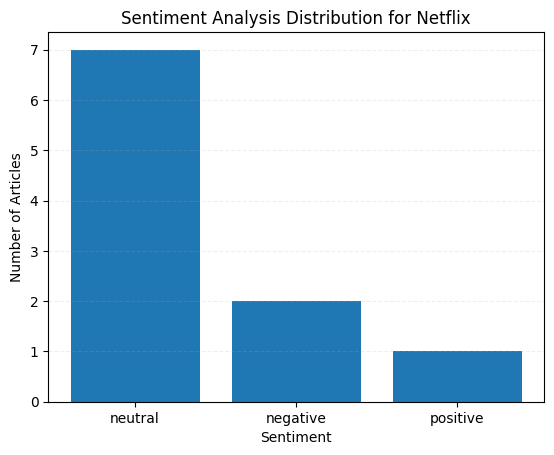

In [76]:
import matplotlib.pyplot as plt
from collections import Counter

# Count sentiments
sentiment_labels = [item["sentiment"] for item in deep_sentiments]
sentiment_counts = Counter(sentiment_labels)

# Prepare data
labels = list(sentiment_counts.keys())
values = list(sentiment_counts.values())

# Plot bar chart
plt.figure()
plt.grid(axis='y', linestyle='--', alpha=0.2)
plt.bar(labels, values)
plt.xlabel("Sentiment")
plt.ylabel("Number of Articles")
plt.title(f"Sentiment Analysis Distribution for {company_name}")
plt.show()




## 📈 Sentiment Polarity Trend

This visualization shows how sentiment polarity changes across a sequence of analyzed articles.

### Purpose
To represent the direction and strength of sentiments over time using a continuous trend.

### Method
- Positive sentiments are plotted above zero.
- Negative sentiments are plotted below zero.
- Neutral sentiments remain at zero.
- Confidence scores determine the magnitude of polarity.

### Output
A line chart displaying sentiment polarity across the selected articles.


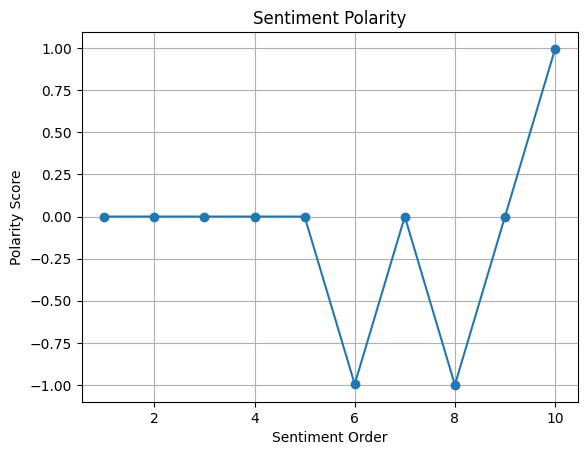

In [77]:
import matplotlib.pyplot as plt

def plot_sentiment_polarity(deep_sentiments, max_points=10):
    """
    Plots a line chart of sentiment polarity.
    Positive -> above 0
    Negative -> below 0
    Neutral  -> on 0
    """

    # Limit to first 10 sentiments
    sentiments = deep_sentiments[:max_points]

    x_values = list(range(1, len(sentiments) + 1))
    y_values = []

    for item in sentiments:
        sentiment = item["sentiment"].lower()
        confidence = item["confidence"]

        if sentiment == "positive":
            y_values.append(confidence)
        elif sentiment == "negative":
            y_values.append(-confidence)
        else:  # neutral
            y_values.append(0)

    # Plot
    plt.figure()
    plt.plot(x_values, y_values, marker='o')

    plt.xlabel("Sentiment Order")
    plt.ylabel("Polarity Score")
    plt.title("Sentiment Polarity")

    plt.grid(True)
    plt.show()

plot_sentiment_polarity(deep_sentiments)


### Closing Price Trend (Last 30 Days)

Plots the company's closing prices over the last 30 days. Dates are formatted as "MM-DD" for readability. To reduce clutter, only every 3rd date is shown on the x-axis.


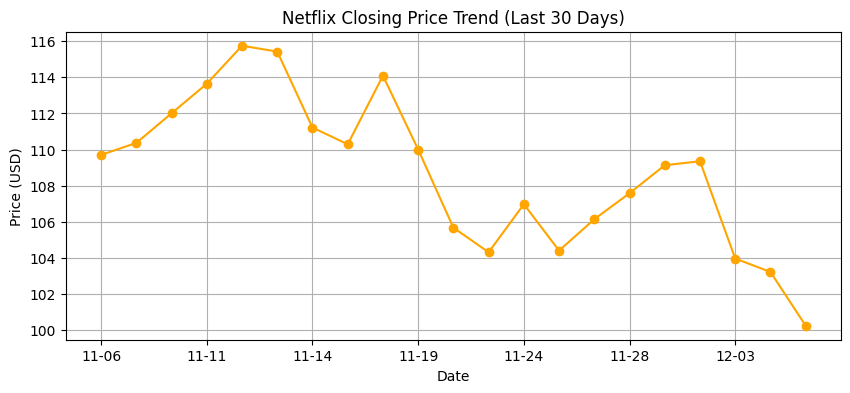

In [78]:
# Convert the dates to "Month-Day" format
market_df["Date_str"] = market_df["Date"].dt.strftime('%m-%d')
plt.figure(figsize=(10,4))
plt.plot(market_df["Date_str"], market_df["Close"], marker='o', color='orange')
plt.title(f"{company_name} Closing Price Trend (Last 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)

N = 3  # fewer labels
plt.xticks(ticks=range(0, len(market_df), N), labels=market_df["Date_str"][::N])
plt.show()


## Using Alpha Vantage for Stock Data


First, install the library:

In [79]:
!pip install alpha_vantage

### Analyze Alpha Vantage Data
Here are some descriptive statistics for the Alpha Vantage data:

In [80]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
from google.colab import userdata

API_KEY = userdata.get('ALPHA_VANTAGE_API')
def detect_symbol(company_name: str) -> str:
    """
    Maps common company/asset names to their typical stock or crypto symbols.
    If no match is found, the name itself is returned as the potential symbol.
    """
    mapping = {
    "BITCOIN": "BTCUSD",
    "BTC": "BTCUSD",

    "TESLA": "TSLA",
    "TSLA": "TSLA",

    "NETFLIX": "NFLX",
    "NFLX": "NFLX",

    "INFOSYS": "INFY",
    "INFY": "INFY",

    "TCS": "TCS",
    "TATA CONSULTANCY": "TCS",

    "RAKUTEN": "RKUNY",

    # ✅ Common U.S. tech
    "APPLE": "AAPL",
    "AAPL": "AAPL",

    "GOOGLE": "GOOG",
    "ALPHABET": "GOOG",
    "GOOG": "GOOG",

    "MICROSOFT": "MSFT",
    "MSFT": "MSFT",

    "AMAZON": "AMZN",
    "AMZN": "AMZN",

    "NVIDIA": "NVDA",
    "NVDA": "NVDA",

    "META": "META",
    "FACEBOOK": "META",

    # ✅ More popular tickers
    "AMD": "AMD",
    "INTEL": "INTC",
    "COCA COLA": "KO",
    "PEPSICO": "PEP",
    "WALMART": "WMT",

    # ✅ Indian stocks (BSE/NSE)
    "RELIANCE": "RELIANCE.BSE",
    "HDFC": "HDFC.BSE",
    "ICICI": "ICICIBANK.BSE",
    "WIPRO": "WIPRO.BSE",
    "HCL": "HCLTECH.BSE",

    # ✅ Crypto
    "ETHEREUM": "ETHUSD",
    "ETH": "ETHUSD",
    "DOGE": "DOGEUSD",
    "DOGECOIN": "DOGEUSD",
    "SOLANA": "SOLUSD",
    "SOL": "SOLUSD",
}

    # Return the mapped symbol or the original name (converted to uppercase for robustness)
    return mapping.get(company_name.upper(), company_name.upper())

    # --- Core Trend Analysis Logic ---
def get_trend(df: pd.DataFrame) -> tuple[str, str]:
    """
    Calculates 20-day and 50-day Simple Moving Averages (SMA) to determine
    the market trend (Bullish, Bearish, or Sideways).
    The '4. close' column is used for calculations.
    """
    df = df.copy()

    # Check for minimum data requirement for a reliable 50-day SMA
    if len(df) < 50:
        return "⚠️ Insufficient Data", "Cannot calculate trend (needs at least 50 days of data)"

    # Calculate SMAs
    # Note: rolling() automatically aligns the mean to the end of the window
    df['SMA20'] = df['4. close'].rolling(window=20).mean()
    df['SMA50'] = df['4. close'].rolling(window=50).mean()

    # Get the latest calculated values
    latest = df.iloc[-1]

    # Handle potential NaN values (occurs if the window is not yet full)
    if pd.isna(latest['SMA20']) or pd.isna(latest['SMA50']):
         return "⚠️ Data Not Yet Complete", "Need more data points for rolling average calculation"

    # Compare SMAs (Golden Cross / Death Cross strategy)
    if latest['SMA20'] > latest['SMA50']:
        return "✅ Bullish Trend", "The short-term trend (SMA20) is above the long-term trend (SMA50). Potential Uptrend."
    elif latest['SMA20'] < latest['SMA50']:
        return "❌ Bearish Trend", "The short-term trend (SMA20) is below the long-term trend (SMA50). Potential Downtrend."
    else:
        return "↔️ Sideways Market", "SMAs are crossing or are too close. Neutral — Wait for a breakout."

# --- Main Execution Block ---
def run_analysis():
    """
    Main function to ask for user input, fetch data, and print the analysis.
    """
    if not API_KEY:
        print("\n❌ Error: ALPHA_VANTAGE_API_KEY is not configured.")
        print("Please set the 'ALPHA_VANTAGE_API_KEY' secret in your environment.")
        return

    # --- ASK USER ---
    try:
        # company_name = input("Enter the company name (e.g., Infosys, Rakuten, Netflix, TCS): ")
        company_name=company_name
    except EOFError:
        # Handle non-interactive environments by using a default
        company_name = "TESLA"
        print(f"Non-interactive environment detected. Using default company: {company_name}")


    if not company_name:
        print("Analysis cancelled: Company name cannot be empty.")
        return

    print(f"\nData analysis will be performed for: {company_name}")

    # --- SYMBOL DETECTION ---
    global symbol
    symbol = detect_symbol(company_name)
    print(f"Using symbol: {symbol}")

    # --- FETCH & PROCESS ---
    try:
        # Initialize the TimeSeries client
        # output_format='pandas' is essential for DataFrame operations
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        global data
        # Fetch daily data (compact size fetches 100 data points, good for 50-day SMA)
        data, meta = ts.get_daily(symbol=symbol, outputsize='compact')
        # Alpha Vantage returns data newest-first, so sort the index (date) oldest-first
        data = data.sort_index()
        # print(data)

        print(f"\n📊 Latest Market Data for {company_name} ({symbol}):")
        # Display the last 3 days of data for review
        print(data[['4. close']].tail(3).to_markdown(numalign="left", stralign="left"))
        global trend, decision
        # Perform the trend analysis
        trend, decision = get_trend(data)

        # Output the results
        print("\n--- Analysis Result ---")
        print(f"Asset: {company_name} ({symbol})")
        print(f"📌 Trend Status: {trend}")
        print(f"🧾 Decision: {decision}")
        print("-----------------------")

    except ValueError as ve:
        # Alpha Vantage throws ValueError on invalid symbol or API key issues
        print(f"\n❌ Error fetching data for {company_name} ({symbol}):")
        print(f"    Details: {ve}")
        print("    Suggestion: Check if the symbol is correct and if the API key is valid.")

    except Exception as e:
        print(f"\n❌ An unexpected error occurred: {e}")

if __name__ == "__main__":
    run_analysis()

UnboundLocalError: cannot access local variable 'company_name' where it is not associated with a value

Now, let's visualize the closing price over time:



In [ ]:
# Ensure data exists
if 'data' in locals() and not data.empty:
  plt.figure(figsize=(12,6))
  plt.plot(data.index, data['4. close'], label='Closing Price', linewidth=2)

  plt.title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  plt.xlabel("Date", fontsize=12)
  plt.ylabel("Closing Price (USD)", fontsize=12)
  plt.legend()
  plt.grid(True, alpha=0.3)
  plt.tight_layout()
  plt.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")

In [ ]:
import plotly.graph_objects as go
# Ensure data is available
if 'data' in locals() and not data.empty:
    fig = go.Figure(data=[
        go.Candlestick(
            x=data.index,
            open=data['1. open'],
            high=data['2. high'],
            low=data['3. low'],
            close=data['4. close'],
            name=f"{company_name}"
        )
    ])

    fig.update_layout(
        title=f"{company_name} ({symbol}) - Candlestick Chart",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        template="plotly_white",
        width=950,
        height=550
    )

    fig.show()
else:
    print("No data available to visualize. Please run the data fetch cell first.")


# Sprint 1 Conclusion
**What we achieved in Sprint 1:**

1. Collected real-time open-source data from:


* Wikipedia (summary)
* Yahoo Finance (market prices)
* Google News RSS (recent headlines)
* Generated synthetic tweets (50) for sentiment analysis

2. Cleaned and structured data using **pandas DataFrames**
3. Performed sentiment analysis using **TextBlob**

4. Visualized key insights:
* Sentiment distribution (bar chart)
* Sentiment trend across tweets (line chart)
* Market price trend (line chart)

5. Built a flexible, interactive notebook for any asset/company input

This notebook sets the foundation for Sprint 2, where we will integrate real-time dashboards and AI-driven analytics.

In [ ]:
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def card(title, content):
    html = f"""
    <div style='border:1px solid #ddd;border-radius:10px;padding:15px;margin:10px;
                background:beige;font-family:sans-serif;color:black;'>
        <h3 style='text-align:center; color:black'>{title}</h3>
        <p style='line-height:1.5; font-color:white;'>{content}</p>
    </div>
    """
    display(HTML(html))


In [ ]:
def dashboard(company, summary, analysis_trend, analysis_decision):
  card(company, summary)
  display(HTML(f"<h2 style='font-size:28px; margin-top:25px;'>Top 10 News Headlines for {company}:</h2>"))
  # Remove quotes around titles
  cleaned_titles = [t.strip("'\"") for t in titles]

  # Create a table
  df = pd.DataFrame({
      "Headline": cleaned_titles,
      "Link": [f'<a href="{l}" target="_blank">Read More</a>' for l in links]
  })

  display(HTML(df.to_html(escape=False, index=False)))

  fig, ax = plt.subplots(1,2, figsize=(17,5))

  # sns.countplot(data=tweets_df, x="Sentiment", hue="Sentiment", palette="viridis", legend=False, ax=ax[0])
  # if news_items:
  sent_df['sentiment'].value_counts().plot(kind='bar', edgecolor='white', ax=ax[0])
  ax[0].set_title(f"Sentiment Distribution for {company} Tweets", fontsize=14, color="white")
  ax[0].set_xlabel("Sentiment", color="white")
  ax[0].set_ylabel("Tweet Count", color="white")


  plt.fill_between(
    range(len(sent_df)),
    sent_df["polarity_score"],
    color="teal",
    alpha=0.1
  )
  sns.lineplot(x=sent_df.index, y=sent_df["polarity_score"], marker='o', linestyle='-', color='teal', ax=ax[1])
  ax[1].set_title(f"Sentiment Polarity Trend Across Texts for {company_name}", color="white")
  ax[1].set_xlabel("Tweet Index",  color="white")
  ax[1].set_ylabel("Polarity Score (-1 = Neg, +1 = Pos)",  color="white")
  ax[1].grid(True)

  # --- Apply dark theme to background and all text elements ---
  for a in ax:
      a.set_facecolor("#222")  # axis background
      a.tick_params(colors="white")  # tick label colors
      for spine in a.spines.values():  # axis borders
          spine.set_color("white")

  # --- Figure background ---
  fig.patch.set_facecolor("#111")
  plt.show()

  analysis_text = f"""
  <div style='font-size:15px;'>
    📌 Asset: {company} ({symbol})<br>
    📈 Trend Status: {analysis_trend}<br>
    ✅ Decision: {analysis_decision}
    </div>
    """

  card("AI analysis Summary", analysis_text)



  fig, ax = plt.subplots(1,2, figsize=(30,10))

  sns.lineplot(x=market_data["Date"], y=market_data["Close"], marker='o', color='orange', ax=ax[0])
  ax[0].set_title(f"{company_name} Closing Price Trend (Last 30 Days)")
  ax[0].set_xlabel("Date")
  ax[0].set_ylabel("Price (USD)")
  ax[0].tick_params(axis='x', rotation=45)


  sns.lineplot(x=data.index, y=data['4. close'], label='Closing Price', linewidth=2, ax=ax[1])
  ax[1].set_title(f"{company_name} ({symbol}) - Closing Price Over Time", fontsize=14)
  ax[1].set_xlabel("Date", fontsize=12)
  ax[1].set_ylabel("Closing Price (USD)", fontsize=12)
  plt.grid(True)
  plt.show()

dashboard(company=company_name, summary=company_summary, analysis_trend=trend, analysis_decision=decision)

# **Slack Alerts Sender**

In [ ]:
# ✅ Slack Alert Sender

import os, json, requests
from datetime import datetime

# ✅ Store your real webhook here for local testing
# (In Colab use: os.environ["SLACK_WEBHOOK_URL"] = userdata.get("SLACK_WEBHOOK_URL"))
SLACK_WEBHOOK_URL = userdata.get("SLACK_WEBHOOK_URL")
def send_slack_alert(data):
    webhook = SLACK_WEBHOOK_URL
    if not webhook:
        print("❌ Slack webhook missing.")
        return

    # ✅ Slack requires at least a "text" field
    payload = {
        "text": f"🚨 {data['alert_type']} for {data['company_name']} ({data['company_ticker']})",
        "blocks": [
            {
                "type": "header",
                "text": {
                    "type": "plain_text",
                    "text": f"{data['alert_type']} — {data['company_ticker']}"
                }
            },
            {
                "type": "section",
                "fields": [
                    {"type": "mrkdwn", "text": f"*Company:*\n{data['company_name']}"},
                    {"type": "mrkdwn", "text": f"*Ticker:*\n{data['company_ticker']}"},
                    # {"type": "mrkdwn", "text": f"*Price:*\n${data['current_price']:.2f}"},
                    {"type": "mrkdwn", "text": f"*Sentiment:*\n{data['sentiment_score']:.2f}"},
                    # {"type": "mrkdwn", "text": f"*Daily Change:*\n{data['daily_change_percent']:.2f}%"},
                    {"type": "mrkdwn", "text": f"*Volatility:*\n{data['volatility_metric']}"},
                ]
            },
            {"type": "divider"},
            {
                "type": "section",
                "text": {
                    "type": "mrkdwn",
                    "text": f"*Recommendation:*\n{data['strategic_action']}"
                }
            },
            {
                "type": "context",
                "elements": [
                    {"type": "mrkdwn", "text": f"Signal Time: {data['signal_time']}"}
                ]
            }
        ]
    }

    r = requests.post(
        webhook,
        data=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )

    if r.status_code == 200:
        print("✅ Slack alert sent successfully!")
    else:
        print("❌ Slack Error:", r.text)
def build_alert(company, ticker, title, body, sentiment):
    return {
        "company_name": company,
        "company_ticker": ticker,
        "alert_type": title,
        "strategic_action": body,
        # "current_price": price,
        "sentiment_score": sentiment,
        # "daily_change_percent": change,
        # "daily_change_absolute": round(price * (change / 100), 2),
        "volatility_metric": "Medium",
        "signal_time": datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    }


In [ ]:
# day_change = ((df.y.iloc[-1] - df.y.iloc[-2]) / df.y.iloc[-2]) * 100
pos_ratio = (sent_df["sentiment"] == "Positive").mean()
neg_ratio = (sent_df["sentiment"] == "Negative").mean()

if pos_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📈 Bullish Sentiment Detected",
        body=f"{company_name} shows strong positive sentiment ({pos_ratio*100:.1f}%).",
        # price=float(df.y.iloc[-1]),
        sentiment=float(pos_ratio),
        # change=float(day_change)
    )
    send_slack_alert(alert)
elif neg_ratio > 0.60:
    alert = build_alert(
        company=company_name,
        ticker=symbol,
        title="📉 Bearish Sentiment Detected",
        body=f"{company_name} shows strong *negative* sentiment ({neg_ratio*100:.1f}%). "
             f"Consider risk management or hedging strategies.",
        # price=float(df.y.iloc[-1]),
        sentiment=float(-neg_ratio),  # negative for clarity if you want
        # change=float(day_change)
    )
    send_slack_alert(alert)
else:
    print("No Slack alert triggered.")
